## Geometry

λ_SiN=0.620 μm, λ_SiO2=0.883 μm


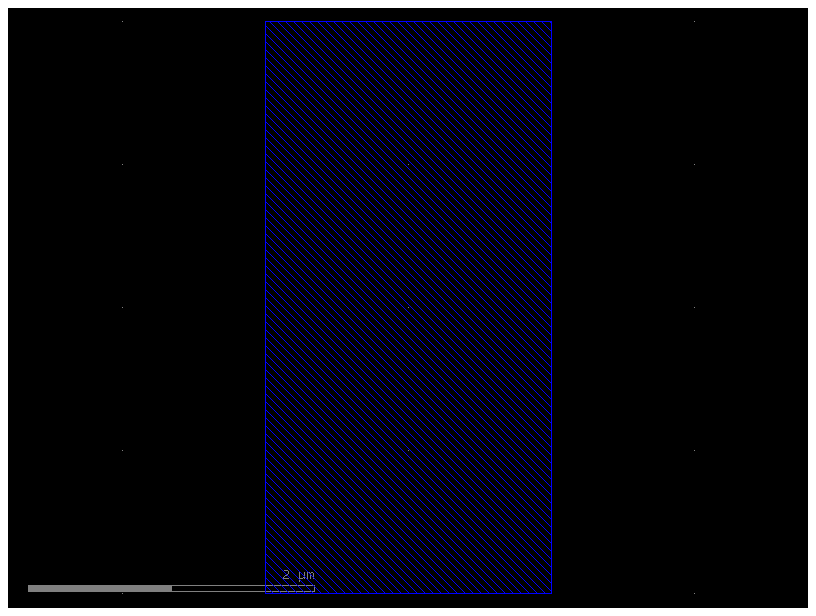

In [10]:
import matplotlib.pyplot as plt
import luminescent as lumi
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import numpy as np

path = "studies/test_PMC"

wavelength = 1.301  # um
channel_separation = 0.02
channel_bandwidth = 0.005

nchannels = 1

channel_wavelengths = [
    wavelength + (c - (nchannels - 1) / 2) * channel_separation
    for c in range(nchannels)
]  # um
wavelengths = sum(
    [
        [wl - channel_bandwidth / 2, wl, wl + channel_bandwidth / 2]
        for i, wl in enumerate(channel_wavelengths)
    ],
    [],
)

eps_Si = 12.25
eps_SiN = 4.3962
eps_SiO2 = 2.1708
n_Si = np.sqrt(eps_Si)
n_SiN = np.sqrt(eps_SiN)
n_SiO2 = np.sqrt(eps_SiO2)

n_grating = n_Si
n_lens = n_SiN
n_clad = n_SiO2
material_grating = "Si"
material_lens = "SiN"
material_clad = "SiO2"

material_library = {
    "Si": lumi.Material(eps_Si),
    "SiO2": lumi.Material(eps_SiO2),
    "SiN": lumi.Material(eps_SiN),
}
material_library["background"] = material_library["SiO2"]  # set background material
material_library["grating"] = lumi.PlaceholderMaterial(n_grating)
material_library["lens"] = lumi.PlaceholderMaterial(n_lens)

w = 2  # gaussian beam waist
r= w / 2  # source gaussian radius
R=2*r
D=2*R  # of design region

λ_Si=wavelength/n_Si
λ_SiN=wavelength/n_SiN
λ_SiO2=wavelength/n_SiO2
print(f"λ_SiN={λ_SiN:.3f} μm, λ_SiO2={λ_SiO2:.3f} μm")

nres = 4  # number of grid points per wavelength in material (not vacuum)
dz=λ_SiO2/ nres
source_port_margin = 2*dz

z_port1 =0
z_port2 =-.5
zmin=z_port2
zmax=z_port1+source_port_margin

BBOX = 10, 0

# makes gdsfadory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left.
c = gf.Component()
# offset = (-l_design/2,-w_design / 2)
# offset = (-R,-w_design / 2)


c.add_polygon([(0,-R), (R,-R), (R,R), (0,R)], layer=BBOX)
c.plot()

## Solve

saving mode plots to studies/test_PMC/modes/1
using simulation folder /home/pxshe/lumi/luminescent/studies/test_PMC


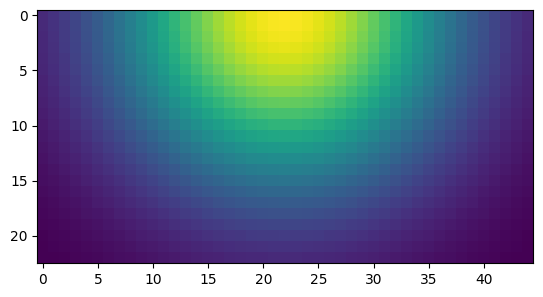

In [11]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
layers = {
}
layer_stack = LayerStack(layers=layers)

# make fiber mode
_dx = λ_Si / nres
nr = round(R/_dx)
_dx=D/nr

x = np.linspace(0,R, nr+1)
y = np.linspace(-R, R, 2*nr+1)
X, Y = np.meshgrid(x, y, indexing='ij')
g = np.exp(-(X**2 + Y**2) / (2 * (w/2) ** 2))
plt.imshow(g, interpolation='nearest', cmap='viridis') # 'viridis' is a common colormap

modes = [
    lumi.Mode(
        fields={
            "Ey": g,
            "Hx": -g * n_SiO2,
        },
        start=[0, -R],
        stop=[R, R],
    ),
]

# additional ports not attached to gdsfactory component
x_port =  0
y_port = 0
ports = [
    lumi.PlanePort(
        name=f"o1",
        origin=[x_port, y_port, z_port1],
        frame=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    ),
    lumi.PlanePort(
        name=f"o2",
        origin=[x_port, y_port, z_port2],
        frame=[[1, 0, 0], [0,- 1, 0], [0, 0, -1]],
    ),
]

sources = [
    lumi.Source(
        f"o1",
        wavelength=wavelength,
        bandwidth=wavelength / 5,
        source_port_margin=source_port_margin,
    )
]



boundaries = [['PMC','PML'], "PML", 'PML']
show_grid = False
views = [
    lumi.View("Ey",x=x_port,y=y_port, z=z_port1),
    lumi.View("Ey",x=x_port,y=y_port, z=z_port2),
    # lumi.View("Ey", z=hs_lens1[-1] / 2 + zmins_lens1[-1],material_color_map=material_color_map,material_library=material_library, show_grid=show_grid, labels=labels),
]
# for i in range(nlens1):
#     views.append(lumi.View("Ey", z=zmins_lens1[i] + h_lens / 2))
# for i in range(nlens2):
#     views.append(lumi.View("Ey", z=zmins_lens2[i] + h_lens / 2))

relative_courant = 0.95
saveat = 1  # save frame every `saveat` periods for movie
# saveat = 1

lumi.make(
    #
    path=path,  # path to make problem folder
    component=c,
    wavelength=wavelength,
    wavelengths=wavelengths,
    ports=ports,
    modes=modes,
    sources=sources,
    boundaries=boundaries,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    zmin=zmin,  # zmin of simulation region
    zmax=zmax,  # zmax of simulation region
    #
    nres=nres,
    relative_courant=relative_courant,
    saveat=saveat,
    #
    views=views,
    # inverse design parameters
    # load_saved_designs=True,
)


failed plotting new frames


Video generated successfully at /home/pxshe/lumi/luminescent/studies/test_PMC/simulation.gif!


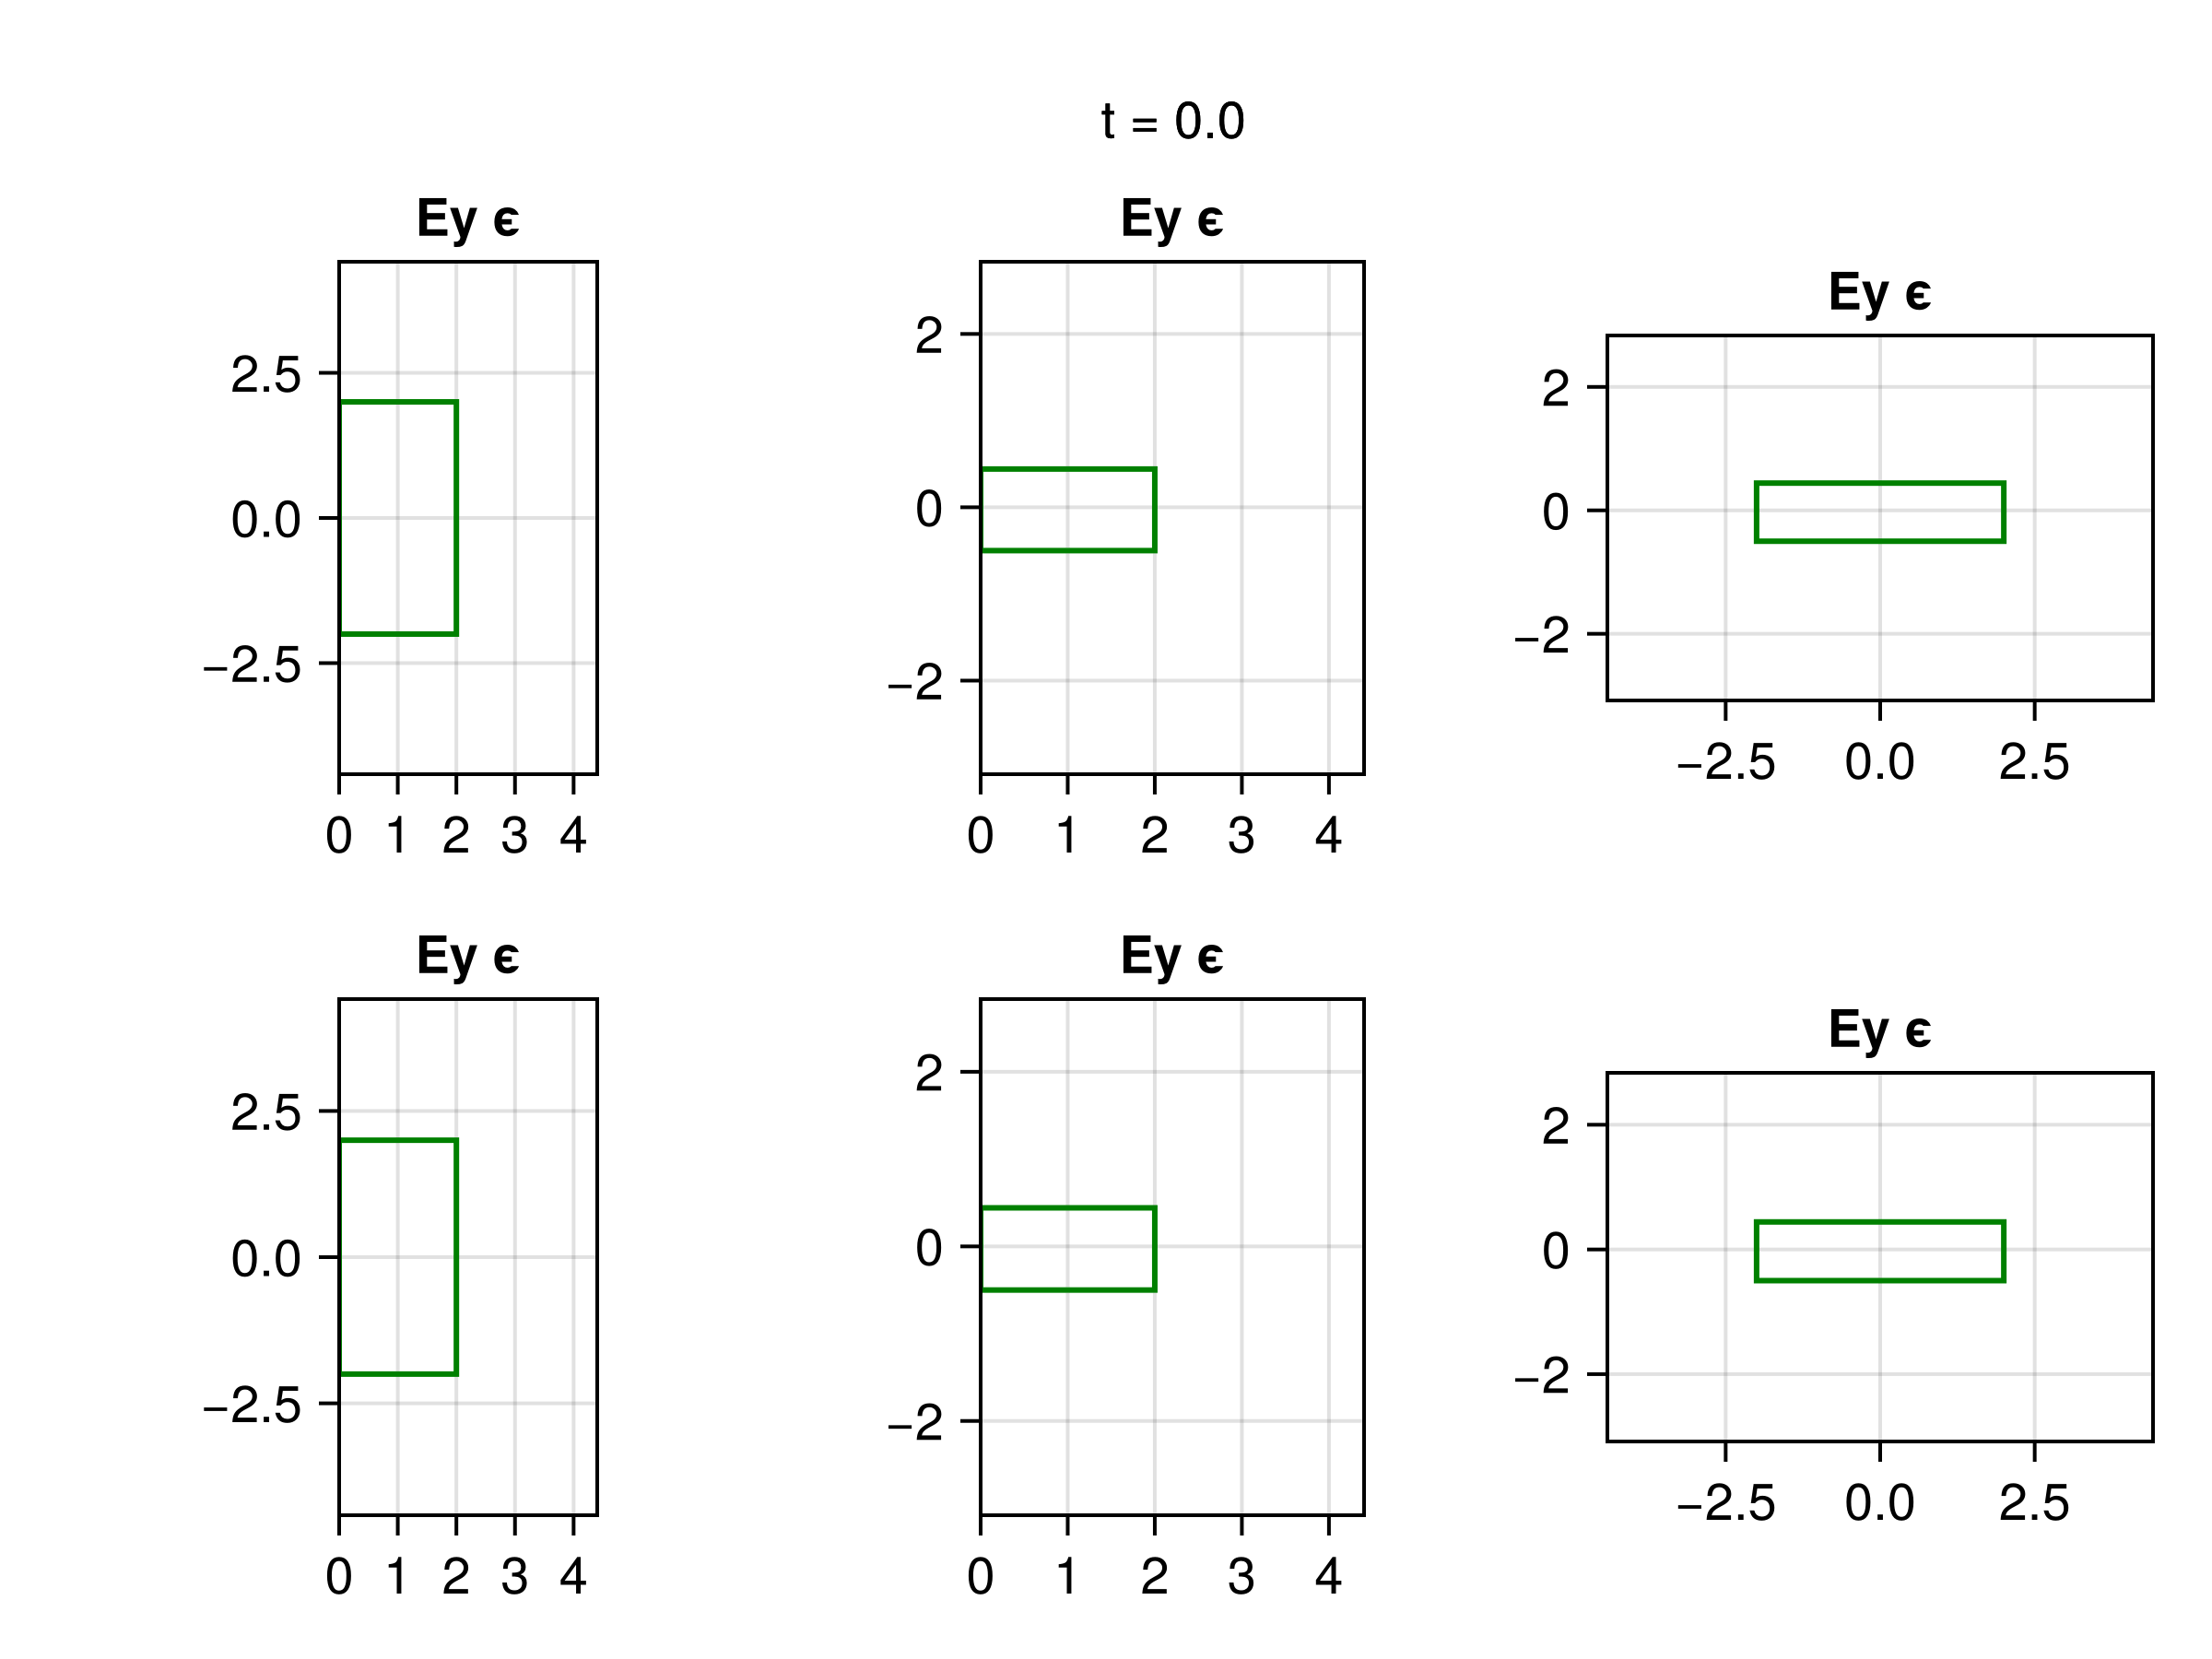

loading solution from /home/pxshe/lumi/luminescent/studies/test_PMC


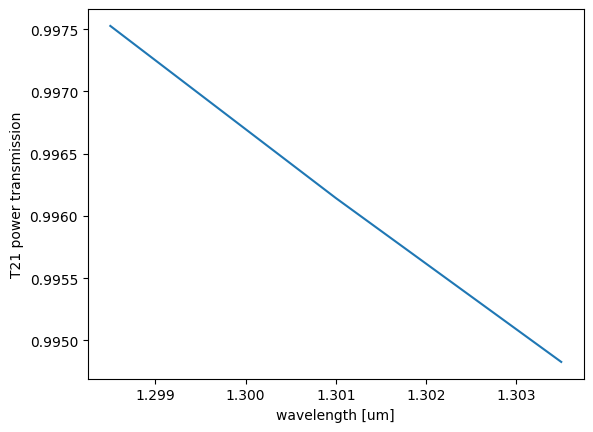

In [12]:
lumi.movie(path)
plt.close()
sol = lumi.load(path)
x = wavelengths

y = lumi.query(sol, "To2@0,o1@0")  # wavelength or frequency ordered depending on problem setup
y = lumi.query(sol, "T2,1")
# y=np.abs2(sol['waves']['o3@0']/sol['waves']['o1@0'])

# y=[10*np.log10(y) for y in y]

plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("T21 power transmission")
plt.show()